### Copyright (C) Infineon Technologies AG 2025
 
Copyright (c) 2025, Infineon Technologies AG, or an affiliate of Infineon Technologies AG. All rights reserved.
This software, associated documentation and materials ("Software") is owned by Infineon Technologies AG or one of its affiliates ("Infineon") and is protected by and subject to worldwide patent protection, worldwide copyright laws, and international treaty provisions. Therefore, you may use this Software only as provided in the license agreement accompanying the software package from which you obtained this Software. If no license agreement applies, then any use, reproduction, modification, translation, or compilation of this Software is prohibited without the express written permission of Infineon.

Disclaimer: UNLESS OTHERWISE EXPRESSLY AGREED WITH INFINEON, THIS SOFTWARE IS PROVIDED AS-IS, WITH NO WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, ALL WARRANTIES OF NON-INFRINGEMENT OF THIRD-PARTY RIGHTS AND IMPLIED WARRANTIES SUCH AS WARRANTIES OF FITNESS FOR A SPECIFIC USE/PURPOSE OR MERCHANTABILITY. Infineon reserves the right to make changes to the Software without notice. You are responsible for properly designing, programming, and testing the functionality and safety of your intended application of the Software, as well as complying with any legal requirements related to its use. Infineon does not guarantee that the Software will be free from intrusion, data theft or loss, or other breaches ("Security Breaches"), and Infineon shall have no liability arising out of any Security Breaches. Unless otherwise explicitly approved by Infineon, the Software may not be used in any application where a failure of the Product or any consequences of the use thereof can reasonably be expected to result in personal injury.

### Notebook Structure
1. **Dataset**
2. **Project Structure**
3. **Keyword Detection Model**
4. **Adding Input Data**
5. **Export and Save Model and Data**
6. **Compiling the Model for AURIX&trade;**
7. **Execution timing PPU vs TC3**

### Keyword Detection

This project demonstrates a neural network that detects English words in a microphone recording. This can be used for wake word detection or giving commands to a car, such as opening the trunk. 

## Dataset
The dataset used to train the Neural Network is the [Google Speech commands dataset v0.02](http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz) which has the following features:

- 35 classes of English words
- 35 speakers
- ~100.000 samples
- noise recordings that can be added to samples (not used in this model)

## Project Structure

```
├── models/
│   ├── KeywordDetecionModel.h5   # Pretrained network
├── out/                          # Example models and generated outputs
│   └── ...                       # Trained models and conversion results
├── keyword_detection.ipynb       # Main analysis notebook
└── metadata.json                 # Information of DEEPCRAFT(TM) Studio Accelerator model
```

## Preparation

Importing necessary helper functions.

In [8]:
import os
import sys

import numpy as np

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from CentralScripts.helper_functions import *
from CentralScripts.python_flask_client import CallTools

import modelling_helper as mh

#### Keyword Detection Model

The structure of the trained network is shown in the following class for reference. 

In [9]:
origin = "tf"  # tf stands for TensorFlow
model_name = "KeywordDetectionModel"

# For reference, this is the model structure of the used model
model = mh.get_model(origin)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 50, 16)         │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 50, 16)         │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 50, 16)         │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 25, 32)         │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 25, 32)         │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 12, 32)         │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 12, 32)         │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 360)            │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 360)            │         1,440 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 36)             │        12,96

 Total params: 98,048 (383.00 KB)

 Trainable params: 97,168 (379.56 KB)

 Non-trainable params: 880 (3.44 KB)

#### Adding Input Data

Now we generate a random input and the corresponding output for model validation.

In [10]:
input_target = np.random.rand(1, 50, 40).astype(np.float32)
output_target = get_predictions(origin, model, input_target)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


#### Export and Save Model and Data

We now export model, input, and output data: 
- the model will be converted into ONNX
- input, and output will be stored as pb.

In [11]:
save_all(model_name, input_target, output_target, model, origin)

Directory already exists: out/KeywordDetectionModel/test_KeywordDetectionModel


#### Compiling the Model for AURIX&trade;

We now generate a C file from the ONNX and convert this into an elf file next. The elf file can be deployed on the CPUs of an AURIX&trade; TC3x. First, we need to ensure that the docker container with all tools is available.

In [12]:
ensure_docker_container()

Docker container 'unruffled_galois' (from image 'aurix_ai_tools:V1.0.1.TriCore') is running at http://localhost:8080/convert


Now, we can run the tools container to convert our model to C code with the AURIX&trade; TC3x as target.

In [13]:
model_folder, onnx_model_file = get_output_paths(model_name)

for target in ["TC3", "TC4"]:
    tool = CallTools(
        folder=model_folder, url="http://localhost:8080/convert", target=target
    )
    tool.convert_model()

Target folder out/KeywordDetectionModel/test_KeywordDetectionModel/TC3 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}
Target folder out/KeywordDetectionModel/test_KeywordDetectionModel/TC4 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}


### Execution timing AURIX&trade; TC4x vs AURIX&trade; TC3x

We now compare the execution timings of both target devices.

Found .log file in TC3 folder: model_conversion.log
Found .log file in TC4 folder: model_conversion.log


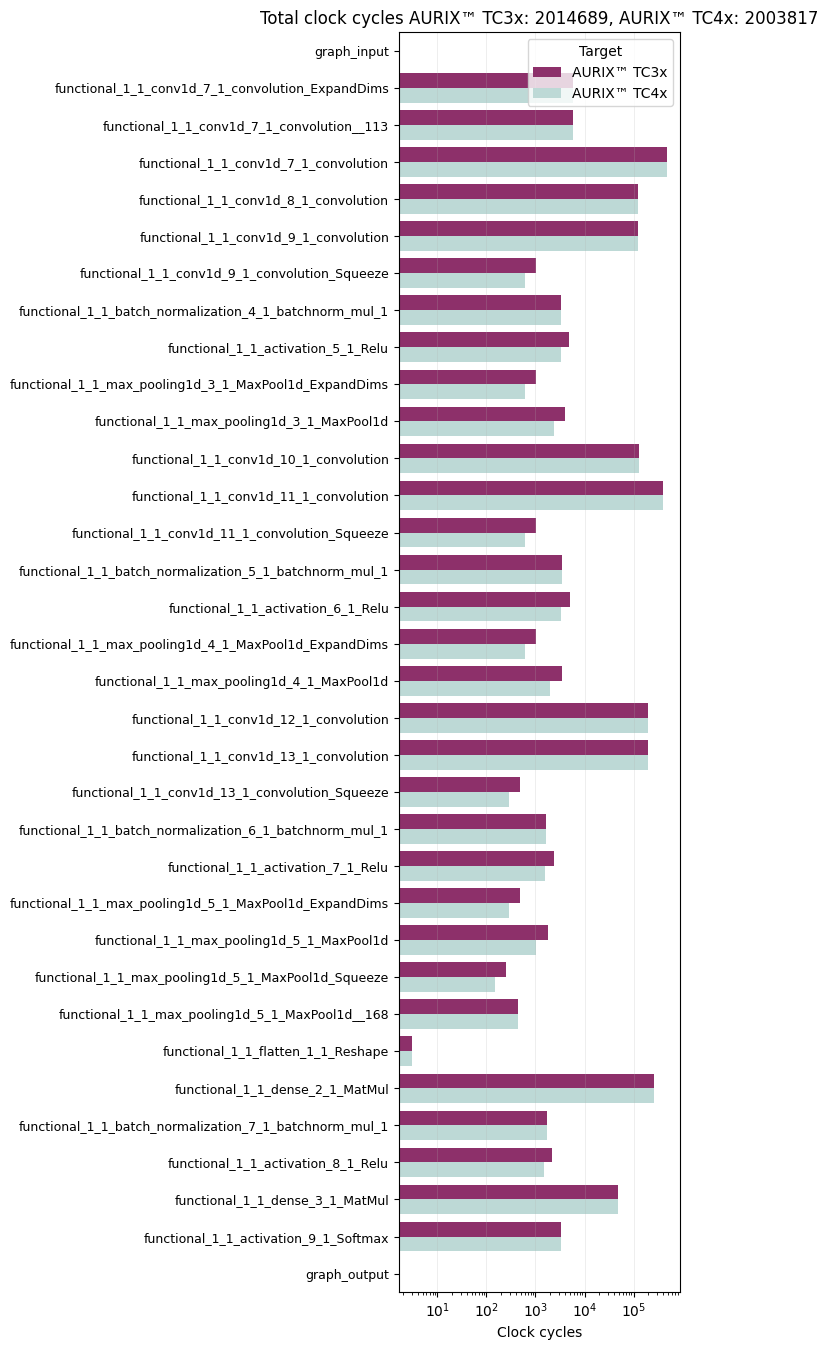

In [14]:
plot_execution_timing(model_name)